### Image search

I'm new to Python and TensorFlow, so I figured I'd take a ridiculous problem and work through it to up my skills. I'll be borrowing / stealing heavily from code found in this vignette
* https://github.com/ml4a/ml4a-guides/blob/master/notebooks/image-search.ipynb

##### Goal
I want to match a randomly uploaded picture of a person with an image of a dog that "looks" like them. I was inspired to do this by my younger brother, Brandon Lisy, who is currently on paternity leave and has simultaneously too little sleep AND too much time.


In [36]:
%matplotlib inline

import os
import random
import pickle
import numpy as np
import matplotlib.pyplot
from matplotlib.pyplot import imshow
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm import tqdm
import scipy.misc
from scipy import ndimage


### import VGG16 and check it out.

In [2]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

# You can inspect the structure of VGG and it's layers here. They're big.
#model.summary()

In [3]:
# Define some helper functions

# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

### Let's look at the image we'll be matching first

VGG is a pre-trained neural network, built by some folks at Oxford. It won first place in ImageNet Challenge 2014 for localisation, and took 2nd place that same year for classification.

More info on VGG is here:
* https://www.kaggle.com/keras/vgg16/home <- download and activity log
* https://arxiv.org/abs/1409.1556 <- VGG Paper


Here's my brother in the flesh

predicted suit with probability 0.553
predicted Windsor_tie with probability 0.254
predicted groom with probability 0.147
predicted bow_tie with probability 0.015
predicted bolo_tie with probability 0.006


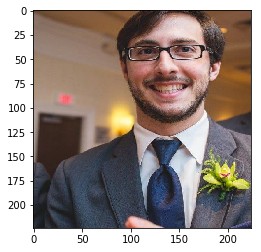

In [4]:
# get the image location.

# Useful for testing.
# rnd = random.randrange(100,273,1)
# rand_str = str(rnd)

img, x = get_image("../image_similarity/people_images/brandon_lisy.jpg")

# call the model and predict
predictions = model.predict(x)

# show the image
imshow(img)

#decode_predictions(predictions)[0]

# loop over the predictions
print("Here's my brother in the flesh\n")
for pred in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred[1], pred[2]))

### Make a new model

OK, so above you can see VGG16 doing it's 'classification' thing - it's trying to see what's in the image. It outputs a predicted probability on it's guess. Top guesses are:

* Suit - 55.3%
* Windsor tie - 25.4%
* Groom - 14.7%


That's all well and good, but I don't want to classify images - I want to find similar images. To do this I can eliminate the final layer of the network. I'll do this by copying the existing model into a new model with one less layer.

In [5]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
#feat_extractor.summary()

### What does the NN know about the image?

The neural network will build out a NumPy array of 4096 attributes. I'll plot them below so as to show the vast inferiority of matplotlib vs ggplot2.

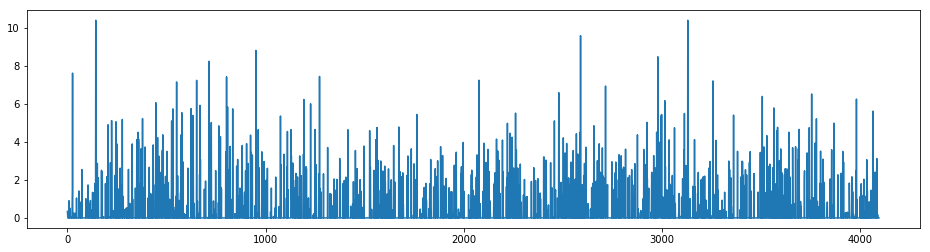

In [6]:
# load the image into feature_extractor
#print('Random image is ' + rand_str + ".jpg")
#img, x = get_image("../image_similarity/people_images/brandon_lisy.jpg")

feat = feat_extractor.predict(x)

# plot the array of activations on the last layer in the neural network
matplotlib.pyplot.figure(figsize=(16,4))
matplotlib.pyplot.plot(feat[0])
matplotlib.pyplot.show()

## Load everything

I've got 1 image (my brother), but what I really want is a list which contains these NumPy arrays. The list should have:

* 20,580 dog pictures
* a few human pictures at the end

This will let me calculate out distances between elements in the list. So... let's get those doggos into a big ole list.



In [7]:
images_path = '../image_similarity/dog_images/'
max_num_images = 20580

images = [os.path.join(dp, f)
          for dp, dn, filenames in os.walk(images_path) 
              for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png''.jpeg']]

# subsets based on max_num_images.
#if max_num_images < len(images):
#    images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]




# append the human images to the images object.
print("keeping %d images to analyze" % len(images))

images.append('../image_similarity/people_images/brandon_lisy.jpg')
# Brandon at 20580
images.append('../image_similarity/people_images/rob.jpg')
# Rob at 20581
images.append('../image_similarity/people_images/neela.jpg')
# Neela at 20582
images.append('../image_similarity/people_images/mountain.png')
# Aaron at 20583


print("keeping %d images to analyze" % len(images) +'\n')

print('List at index 1 ' + str(images[1]))
print('List at index 20580 ' + str(images[20580]))
print('List at index 20581 ' + str(images[20581]))
print('List at index 20582 ' + str(images[20582]))
print('List at index 20583 ' + str(images[20583]))

keeping 20580 images to analyze
keeping 20584 images to analyze

List at index 1 ../image_similarity/dog_images/1524.jpg
List at index 20580 ../image_similarity/people_images/brandon_lisy.jpg
List at index 20581 ../image_similarity/people_images/rob.jpg
List at index 20582 ../image_similarity/people_images/neela.jpg
List at index 20583 ../image_similarity/people_images/mountain.png


### Prepare the features

So, we generated those NumPy arrays above before for 1 image... now let's generate these same arrays for all 20k.

This takes a while.

In [25]:
# big loop to load all the images and their features.
features = []
for image_path in tqdm(images):
    img, x = get_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

100%|██████████| 20584/20584 [49:35<00:00,  6.92it/s]


## Write to disk

I don't want to do that again... write the features object to disk so we can reload if needed.

In [10]:
#np.save('../image_similarity/features.npy', features)
#print('Length of array is: ' + str(len(features)) +' items')
features = np.load('../image_similarity/features.npy')

print('The restored NumPy set is ' + str(len(features)) + ' items long')

The restored NumPy set is 20584 items long


### Reduce the arrays through PCA

We don't actually _need_ 4096 attributes for every image, so I've been told we can do Principal Component Analysis to reduce the dimensions.

More light reading: https://en.wikipedia.org/wiki/Principal_component_analysis


In [11]:
features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

print('NumPy array with dimensions: '+ str(features.shape))

NumPy array with dimensions: (20584, 4096)


## Save to disk

Just like the features, I can skip re-doing the PCA if I simply write this stuff out to disk and reload from it if necessary.

In [12]:
# write the numpy array to a file
np.save('../image_similarity/np_array.npy', pca_features)

#testing the save an reload of the NumPy array we just wrote out.
pca_features = np.load(file='../image_similarity/np_array.npy')
print(len(pca_features))


20584


In [28]:
# NB: that 'len(distances)-5' part should exclude the people who are at the END of the array.

# helper functions
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.euclidean(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)-5), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Querying for Brandon at index 20580


Text(0.5,1,'result images')

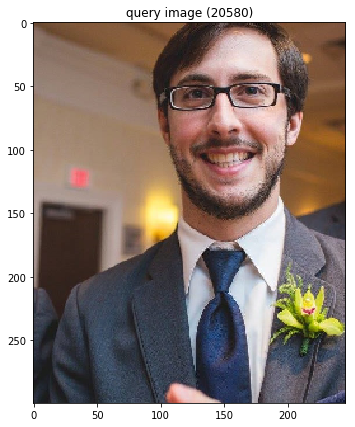

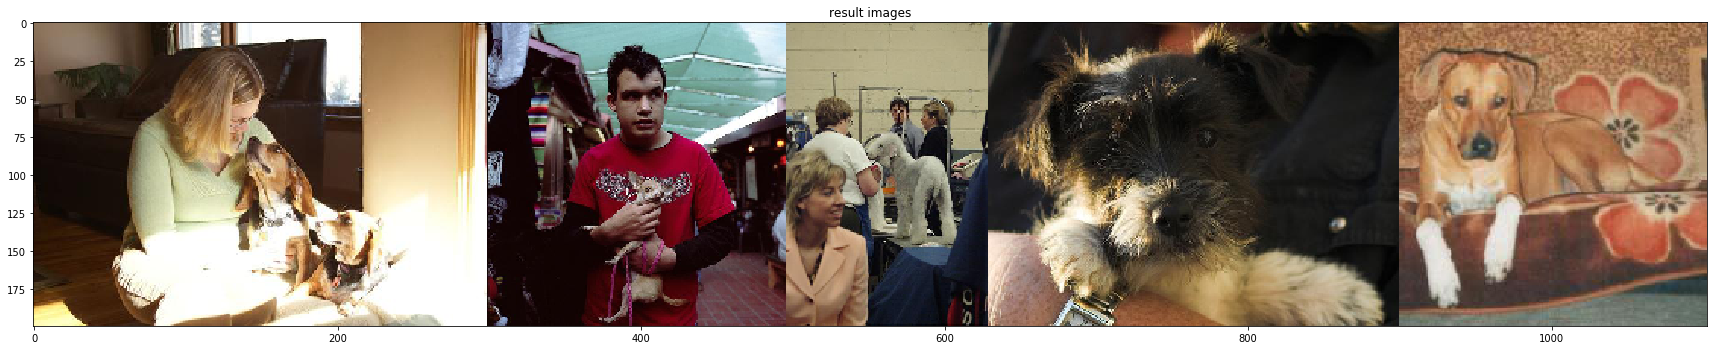

In [29]:
# Option A:
    # do a query on a random image
    # pick a rando image
# query_image_idx = int(len(images) * random.random())

    
# Option B:
    # hard code the person image.
query_image_idx = int(20580)
print('Querying for Brandon at index ' + str(query_image_idx))

idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
matplotlib.pyplot.figure(figsize = (7,7))
imshow(query_image)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)

# display the resulting images
matplotlib.pyplot.figure(figsize = (30,25))
imshow(results_image)
matplotlib.pyplot.title("result images")

Querying for Rob at index 20581


Text(0.5,1,'result images')

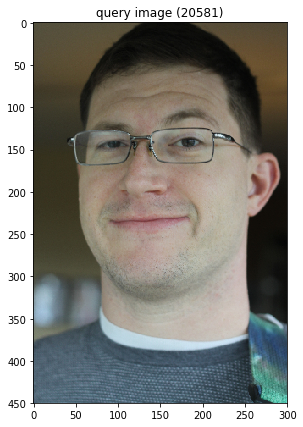

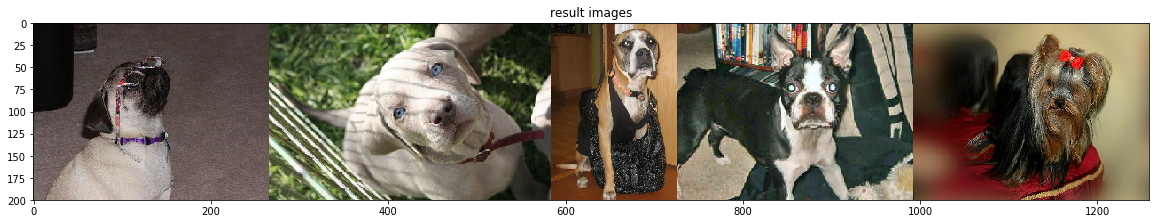

In [41]:
# let's do Rob's pic
query_image_idx = int(20581)
print('Querying for Rob at index ' + str(query_image_idx))


idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
matplotlib.pyplot.figure(figsize = (7,7))
imshow(ndimage.rotate(query_image, -90)) # Rob's a bit rotated... rotate him back.
matplotlib.pyplot.title("query image (%d)" % query_image_idx)

# display the resulting images
matplotlib.pyplot.figure(figsize = (20,16))
imshow(results_image)
matplotlib.pyplot.title("result images")

Querying for Neela at index 20582


Text(0.5,1,'result images')

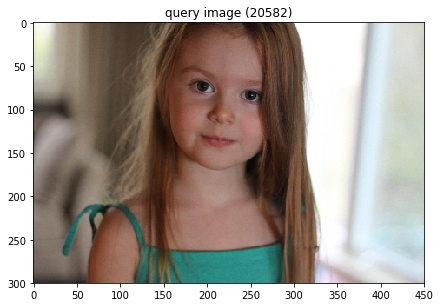

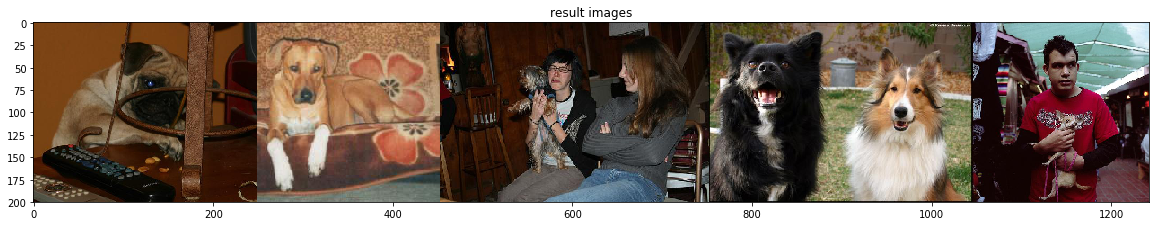

In [32]:
query_image_idx = int(20582)
print('Querying for Neela at index ' + str(query_image_idx))

idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
matplotlib.pyplot.figure(figsize = (7,7))
imshow(query_image)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)

# display the resulting images
matplotlib.pyplot.figure(figsize = (20,16))
imshow(results_image)
matplotlib.pyplot.title("result images")

Querying for Aaron at index 20583


Text(0.5,1,'result images')

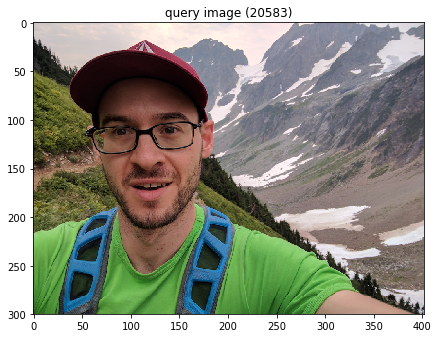

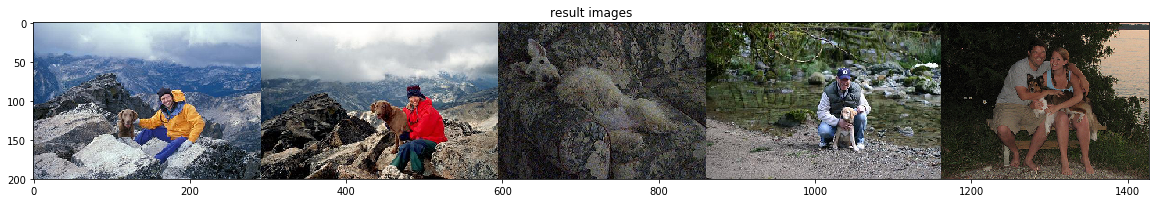

In [33]:
query_image_idx = int(20583)
print('Querying for Aaron at index ' + str(query_image_idx))

idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
matplotlib.pyplot.figure(figsize = (7,7))
imshow(query_image)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)

# display the resulting images
matplotlib.pyplot.figure(figsize = (20,16))
imshow(results_image)
matplotlib.pyplot.title("result images")